In [116]:
import pandas as pd
import numpy as np
from datetime import datetime
from math import radians, cos, sin, asin, sqrt

# import de data set
df_01 = pd.read_csv('datasets/train.csv', delimiter = ',', encoding = 'latin-1', low_memory = False)
df_01.shape

(250306, 34)

In [178]:
df_06['discount_amount'].head()

0    0.0
1    0.0
2    0.0
4    0.0
5    0.0
Name: discount_amount, dtype: float64

In [117]:
df_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
ticket_id                     250306 non-null int64
agency_name                   250306 non-null object
inspector_name                250306 non-null object
violator_name                 250272 non-null object
violation_street_number       250306 non-null float64
violation_street_name         250306 non-null object
violation_zip_code            0 non-null float64
mailing_address_str_number    246704 non-null float64
mailing_address_str_name      250302 non-null object
city                          250306 non-null object
state                         250213 non-null object
zip_code                      250305 non-null object
non_us_str_code               3 non-null object
country                       250306 non-null object
ticket_issued_date            250306 non-null object
hearing_date                  237815 non-null object
violation_code                250306 non-null obj

We can see that the dataset contains 250306 samples in total but it has only 159880 samples for
the target value. We will have to remove all the samples with a null value during cleaning.
We can also notice that the features "violaton_zip_code", "non_us_str_code", "grafitti_status" and "collection_status" have a lot of missing values and will therefore also be removed.

In [118]:
df_01 = df_01.drop(['violation_zip_code','non_us_str_code','grafitti_status'], 1)

In [119]:
test_data = pd.read_csv('datasets/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61001 entries, 0 to 61000
Data columns (total 27 columns):
ticket_id                     61001 non-null int64
agency_name                   61001 non-null object
inspector_name                61001 non-null object
violator_name                 60973 non-null object
violation_street_number       61001 non-null float64
violation_street_name         61001 non-null object
violation_zip_code            24024 non-null object
mailing_address_str_number    59987 non-null object
mailing_address_str_name      60998 non-null object
city                          61000 non-null object
state                         60670 non-null object
zip_code                      60998 non-null object
non_us_str_code               0 non-null float64
country                       61001 non-null object
ticket_issued_date            61001 non-null object
hearing_date                  58804 non-null object
violation_code                61001 non-null object
violation_

In [122]:
#colums not in common
col_diff = [x for x in df_01.columns if x not in test_data.columns]
col_diff

['compliance']

In [121]:
#We need to remove from the training set the columns that are not present in the test set (except target)
df_01 = df_01.drop(['payment_amount','balance_due','payment_date','payment_status','collection_status',
                    'compliance_detail'], 1)

In [123]:
len(df_01)+len(test_data)

311307

In [124]:
addresses = pd.read_csv('datasets/addresses.csv', delimiter = ',', encoding = 'latin-1')
len(addresses)

311307

In [125]:
addresses.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [126]:
unique_adresses = addresses.drop_duplicates(subset=['address'], keep=False)
len(unique_adresses)

54779

In [127]:
latlons = pd.read_csv('datasets/latlons.csv', delimiter = ',', encoding = 'latin-1')
len(latlons)

121769

In [128]:
latlons.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


In [129]:
# import de external data files and merge them to the data set
addresses = pd.read_csv('datasets/addresses.csv', delimiter = ',', encoding = 'latin-1') # 311.307 records
latlons = pd.read_csv('datasets/latlons.csv', delimiter = ',', encoding = 'latin-1') # 121.769 records

# merge addresses to training dataset, 250.306 records -> every record has a known address
df_02 = pd.merge(df_01, addresses, left_on = ['ticket_id'], right_on = ['ticket_id'], how = 'inner')

# merge latitudes and longitudes to training dataset, 250.306 records -> every record has a latitude and
# longitude but possibly the wrong ones due to a misspelled address
df_03 = pd.merge(df_02, latlons, left_on = ['address'], right_on = ['address'], how = 'inner')

# remove records where compliance equals 'Null', 159.880 records
df_04 = df_03.dropna(subset = ['compliance'])

df_02.shape, df_03.shape, df_04.shape

((250306, 26), (250306, 28), (159880, 28))

In [142]:
# make all codes with less than 10 occurrences null in order not to end up with to many dummies later
df_05 = df_04.copy()

features_to_reduce = ['violation_description', 'agency_name', 'disposition', 'state']
    
for feature in features_to_reduce:
    number_categories_before = df_05[feature].value_counts(dropna = False).to_frame().shape[0]
    counts = df_05[feature].value_counts()
    df_05.loc[df_05[feature].isin(counts[counts < 10].to_frame().reset_index()['index']), feature] = np.nan
    number_categories_after = df_05[feature].value_counts(dropna = False).to_frame().shape[0]
    
    print('The number of categories of', feature, 'is reduced from', number_categories_before, 'to', number_categories_after)

The number of categories of violation_description is reduced from 207 to 98
The number of categories of agency_name is reduced from 5 to 5
The number of categories of disposition is reduced from 4 to 4
The number of categories of state is reduced from 60 to 50


In [143]:
# create a new feature: the gap in days between the date the ticket has been issued and the hearing date
def time_gap(input1, input2):
    if not input1 or type(input1) != str: return np.nan
    date1 = datetime.strptime(input1, "%Y-%m-%d %H:%M:%S")
    date2 = datetime.strptime(input2, "%Y-%m-%d %H:%M:%S")
    difference = date1 - date2
    return difference.days
    
df_05['time_gap'] = df_05.apply(lambda row: time_gap(row['hearing_date'], row['ticket_issued_date']), axis = 1).astype(np.float64)

A gap up to 100 days seems realistic, however negative gaps (the ticket has been issued after the hearing data) and
very large gaps of over 365 (one year) seem incorrect. These 'outliers' or errors in the data will be replace by the average.


In [144]:
# first we will check how many records contain such gaps
df_05[(df_05['time_gap'] < 0) | (df_05['time_gap'] > 365)]['time_gap'].count()

453

In [145]:
df_06 = df_05.copy()
# let's replace these values and the missings already in the dataframe by the average timegap of the non-missings
df_06.loc[(df_06['time_gap'] < 0) | (df_06['time_gap'] > 365), 'time_gap'] = np.nan

mean_time_gap = df_06['time_gap'].mean()
df_06['time_gap'].fillna(mean_time_gap, inplace = True)

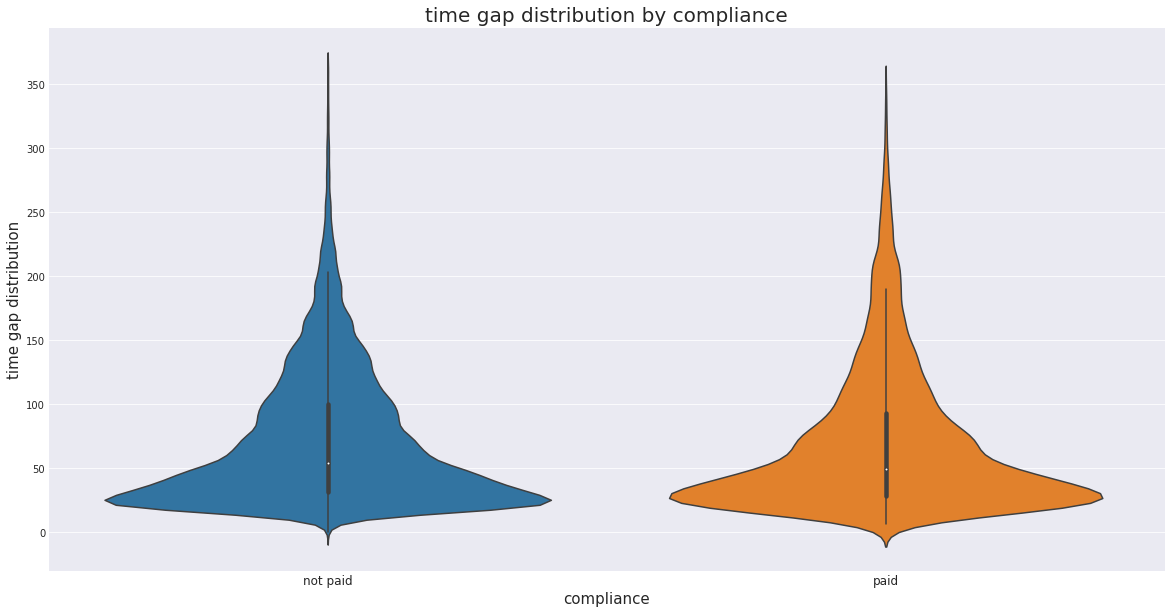

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

plt.figure(figsize = (20, 10))

p = sns.violinplot(data = df_06, x = 'compliance', y = 'time_gap')
p.set_title('time gap distribution by compliance', fontsize = 20)
p.set_xlabel('compliance', fontsize = 15)
p.set_ylabel('time gap distribution', fontsize = 15) 
p.set_xticklabels(['not paid', 'paid'], fontsize = 12)

plt.show()

In [159]:
# impute missing values in lat with the average, lon with the average and state with a 'new state' (as in 'other')
mean_lat = df_06['lat'].mean()
mean_lon = df_06['lon'].mean()

df_06['lat'].fillna(mean_lat, inplace = True)
df_06['lon'].fillna(mean_lon, inplace = True)
df_06['state'].fillna('ZZ', inplace = True)

In [160]:
# create the distance of every address to the city of Detroit    
def haversine(lon1, lat1, lon2, lat2):

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371 # radius of earth in kilometers (use 3956 for miles)
    return c * r

# longitude and latitude of Detroit are -83.045753 and 42.331429
df_06['distance'] = df_06.apply(lambda row: haversine(lon1 = -83.045753,
                                                      lat1 = 42.331429,
                                                      lon2 = row['lon'],
                                                      lat2 = row['lat']), axis = 1)

In [161]:
df_06['distance'].groupby(df_06['compliance']).describe()

,count,mean,std,min,25%,50%,75%,max
compliance,,,,,,,,
0.0,148283.0,11.364780,4.296246,0.036816,8.432334,11.47135,13.964312,275.624714
1.0,11597.0,11.095243,4.536442,0.084815,7.711914,11.42643,13.943130,38.978889


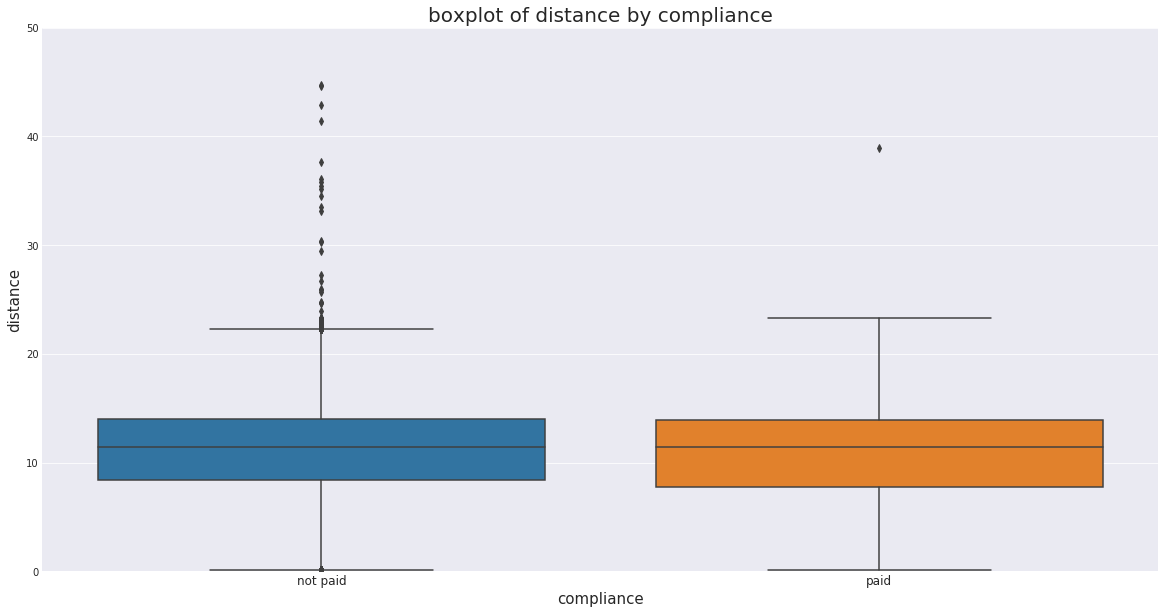

In [162]:
plt.figure(figsize = (20, 10))

bp = sns.boxplot(x = 'compliance', y = 'distance', data=df_06)
bp.set(ylim = (0, 50))
bp.set_title('boxplot of distance by compliance', fontsize = 20)
bp.set_xlabel('compliance', fontsize = 15)
bp.set_ylabel('distance', fontsize = 15) 
bp.set_xticklabels(['not paid', 'paid'], fontsize = 12)

plt.show()

In [163]:
# create some additional features
df_07 = df_06.copy()

df_07.loc[:, 'distance2']          = df_07.loc[:, 'distance'] * df_07.loc[:, 'distance']
df_07.loc[:, 'distance_admin_fee'] = df_07.loc[:, 'distance'] * df_07.loc[:, 'admin_fee']
df_07.loc[:, 'distance_state_fee'] = df_07.loc[:, 'distance'] * df_07.loc[:, 'state_fee']
df_07.loc[:, 'distance_late_fee']  = df_07.loc[:, 'distance'] * df_07.loc[:, 'late_fee']
df_07.loc[:, 'distance_discount']  = df_07.loc[:, 'distance'] * df_07.loc[:, 'discount_amount']
df_07.loc[:, 'distance_judgment']  = df_07.loc[:, 'distance'] * df_07.loc[:, 'judgment_amount']
df_07.loc[:, 'distance_time_gap']  = df_07.loc[:, 'distance'] * df_07.loc[:, 'time_gap']

In [164]:
# selecting the features
feature_names = ['ticket_id', 'violation_description', 'agency_name', 'disposition', 'discount_amount',
                 'admin_fee', 'state_fee', 'late_fee', 'judgment_amount', 'state', 'lat', 'lon', 'distance', 'time_gap',
                 'distance2', 'distance_admin_fee', 'distance_state_fee', 'distance_late_fee', 'distance_discount',
                 'distance_judgment', 'distance_time_gap']

x = df_07[feature_names]
x = x.set_index('ticket_id')

y = df_07['compliance']

# recoding the categorical features to numerical ones
x['violation_description'] = x['violation_description'].astype('category')
violation_description_dict = dict(enumerate(x.violation_description.cat.categories))
violation_description_dict2 = {y:x for x,y in violation_description_dict.items()}
x['violation_description'] = x['violation_description'].cat.codes
mode_violation_description = x['violation_description'].mode()[0]

x['agency_name'] = x['agency_name'].astype('category')
agency_name_dict = dict(enumerate(x.agency_name.cat.categories))
agency_name_dict2 = {y:x for x,y in agency_name_dict.items()}
x['agency_name'] = x['agency_name'].cat.codes
mode_agency_name = x['agency_name'].mode()[0]

x['disposition'] = x['disposition'].astype('category')
disposition_dict = dict(enumerate(x.disposition.cat.categories))
disposition_dict2 = {y:x for x,y in disposition_dict.items()}
x['disposition'] = x['disposition'].cat.codes
mode_disposition = x['disposition'].mode()[0]

x['state'] = x['state'].astype('category')
state_dict = dict(enumerate(x.state.cat.categories))
state_dict2 = {y:x for x,y in state_dict.items()}
x['state'] = x['state'].cat.codes

In [165]:
# some of the features are numerical but have no order so it's better to convert them to dummies
feature_to_be_splitted = ['violation_description', 'agency_name', 'disposition', 'state']
    
x = pd.get_dummies(x, columns = feature_to_be_splitted)

In [166]:
corr = x.corr().abs()
s = corr.unstack().to_frame().reset_index()
s.columns = ['Feature1', 'Feature2', 'Correlation']
s[(s['Correlation'] > 0.9) & (s['Correlation'] <= 0.99)].sort_values('Correlation', ascending = False)

,Feature1,Feature2,Correlation
2090,distance_late_fee,distance_judgment,0.989240
2434,distance_judgment,distance_late_fee,0.989240
523,late_fee,judgment_amount,0.989070
695,judgment_amount,late_fee,0.989070
531,late_fee,distance_late_fee,0.940410
2079,distance_late_fee,late_fee,0.940410
13,discount_amount,distance_discount,0.938221
2249,distance_discount,discount_amount,0.938221
706,judgment_amount,distance_judgment,0.936776
2426,distance_judgment,judgment_amount,0.936776


In [167]:
# remove some features that cause multicollinearity
#   - distance_judgment
#   - late_fee
#   - discount_amount

multicollinearity = ['distance_judgment', 'late_fee', 'discount_amount']

features_no_multi = [feature for feature in x.columns if feature not in multicollinearity]
x_no_multi = x[features_no_multi]

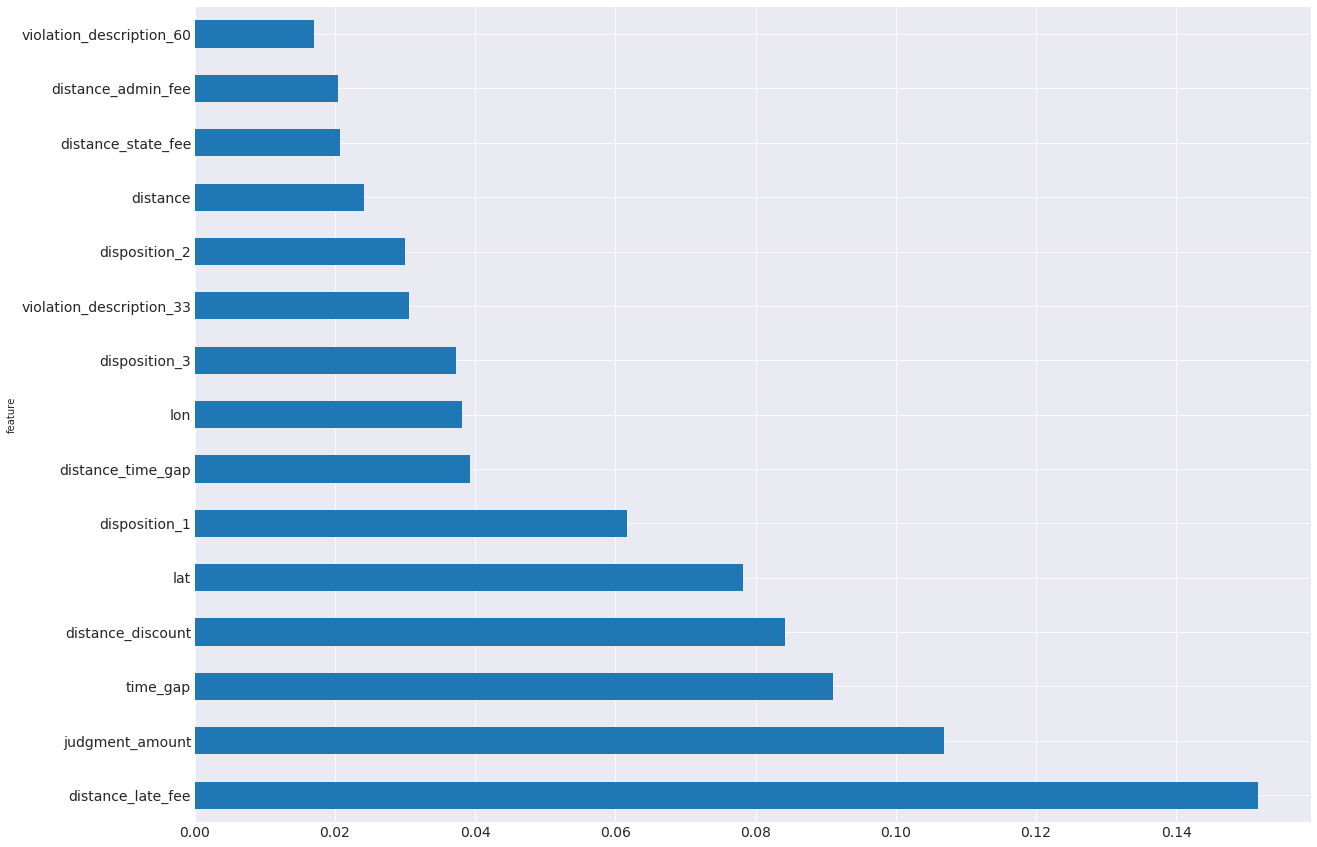

In [168]:
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot as plt

clf = GradientBoostingClassifier(random_state = 0).fit(x_no_multi, y)

features = []

for feature, importance in zip(x_no_multi.columns, clf.feature_importances_):
    features.append((importance, feature))

features.sort(reverse = True)
features_relevant = [x_no_multi[1] for x_no_multi in features if x_no_multi[0] > 0]

features = pd.DataFrame()

features['feature'] = x_no_multi.columns
features['importance'] = clf.feature_importances_

features.sort_values(by = ['importance'], ascending = True, inplace = True)
features.set_index('feature', inplace = True)

# plot the 'top 15' features
features[:-16:-1].plot(kind = 'barh', figsize = (20, 15), legend = None)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.show()

In [185]:
# apply the same transformations as done on the training data
test_data_02 = pd.merge(test_data, addresses, left_on = ['ticket_id'], right_on = ['ticket_id'], how = 'inner')
test_data_03 = pd.merge(test_data_02, latlons, left_on = ['address'], right_on = ['address'], how = 'inner')
    
for feature in features_to_reduce:
    number_categories_before = test_data_03[feature].value_counts(dropna = False).to_frame().shape[0]
    counts = test_data_03[feature].value_counts()
    test_data_03.loc[test_data_03[feature].isin(counts[counts < 10].to_frame().reset_index()['index']), feature] = np.nan
    number_categories_after = test_data_03[feature].value_counts(dropna = False).to_frame().shape[0]

test_data_03['time_gap'] = test_data_03.apply(lambda row: time_gap(row['hearing_date'], 
                                                                   row['ticket_issued_date']), axis = 1).astype(np.float64)
test_data_03['time_gap'] = np.where((test_data_03['time_gap'] < 0) | 
                                    (test_data_03['time_gap'] > 365), np.nan, test_data_03['time_gap'])
test_data_03['time_gap'].fillna(mean_time_gap, inplace = True)

test_data_03['lat'].fillna(mean_lat, inplace = True)
test_data_03['lon'].fillna(mean_lon, inplace = True)
test_data_03['state'].fillna('ZZ', inplace = True)

test_data_03['distance'] = test_data_03.apply(lambda row: 
                                          haversine(lon1 = -83.045753, lat1 = 42.331429, lon2 = row['lon'], lat2 = row['lat']), axis = 1)

test_data_03['distance2'] = test_data_03['distance'] * test_data_03['distance']
test_data_03['distance_admin_fee'] = test_data_03['distance'] * test_data_03['admin_fee']
test_data_03['distance_state_fee'] = test_data_03['distance'] * test_data_03['state_fee']
test_data_03['distance_late_fee'] = test_data_03['distance'] * test_data_03['late_fee']
test_data_03['distance_discount'] = test_data_03['distance'] * test_data_03['discount_amount']
test_data_03['distance_judgment'] = test_data_03['distance'] * test_data_03['judgment_amount']
test_data_03['distance_time_gap'] = test_data_03['distance'] * test_data_03['time_gap']

test_data_03['violation_description'] = test_data_03['violation_description'].map(violation_description_dict2)
test_data_03['violation_description'].fillna(mode_violation_description, inplace = True)
test_data_03['violation_description'] = test_data_03['violation_description'].astype(np.int8)

test_data_03['agency_name'] = test_data_03['agency_name'].map(agency_name_dict2)
test_data_03['agency_name'].fillna(mode_agency_name, inplace = True)
test_data_03['agency_name'] = test_data_03['agency_name'].astype(np.int8)

test_data_03['disposition'] = test_data_03['disposition'].map(disposition_dict2)
test_data_03['disposition'].fillna(mode_disposition, inplace = True)
test_data_03['disposition'] = test_data_03['disposition'].astype(np.int8)

test_data_03['state'] = test_data_03['state'].map(state_dict2)
test_data_03['state'].fillna(49, inplace = True)
test_data_03['state'] = test_data_03['state'].astype(np.int8)

test_data_03 = pd.get_dummies(test_data_03, columns = feature_to_be_splitted)

test_data_03 = test_data_03.set_index('ticket_id')

In [188]:
# make sure the algorithm is not being trained on features not available in the test set
train_features = x_no_multi[features_relevant].columns
train_features_set = set(train_features)
    
for feature in set(train_features):
    if feature not in test_data_03:
        train_features_set.remove(feature)
train_features = list(train_features_set)
    
x_input = x[train_features]
test_data_03 = test_data_03[train_features]

In [193]:
x_input.shape, test_data_03.shape

((159880, 53), (61001, 53))

In [194]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

x_train, x_val, y_train, y_val = train_test_split(x_input, y, random_state = 0)

clf = GradientBoostingClassifier(learning_rate = 0.03, max_depth = 5, random_state = 0).fit(x_train, y_train)

# area under the curve (AUC) score for training dataset
y_train_score = clf.predict_proba(x_train)[:,1]
roc_auc_train = roc_auc_score(y_train, y_train_score)
    
# area under the curve (AUC) score for test dataset
y_val_score = clf.predict_proba(x_val)[:,1]
roc_auc_val = roc_auc_score(y_val, y_val_score)

print('ROC for training set: ', "{0:.3f}".format(roc_auc_train))
print('ROC for the validation set: ', "{0:.3f}".format(roc_auc_val))

ROC for training set:  0.824
ROC for the validation set:  0.814


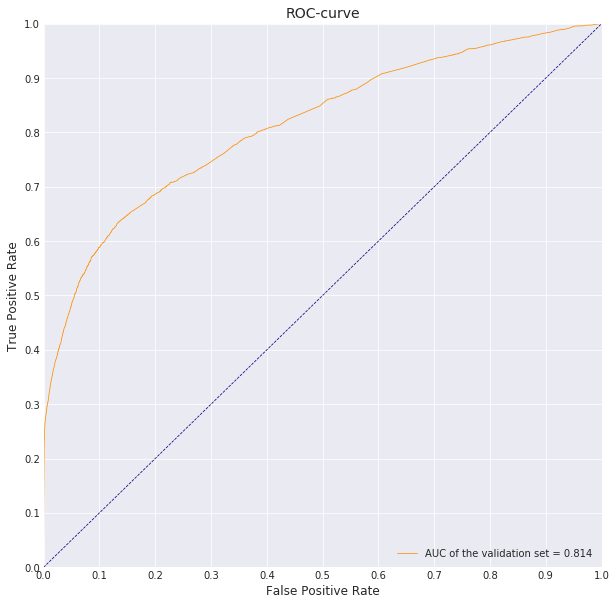

In [195]:
# plot the ROC-curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_val, y_val_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10, 10))

ax = plt.gca()

plt.title('ROC-curve', fontsize = 14)
plt.plot(fpr, tpr, color = 'darkorange', lw = 0.75, label = 'AUC of the validation set = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 0.75, linestyle = '--')

xticks_major = np.round(np.linspace(0, 1, 11), 1)
xticks_major_str = (xticks_major).astype(str).tolist()
xticks_labels = [x for x in xticks_major_str]

yticks_major = np.round(np.linspace(0, 1, 11), 1)
yticks_major_str = (yticks_major).astype(str).tolist()
yticks_labels = [x for x in yticks_major_str]

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xticks(xticks_major)
ax.set_xticklabels(xticks_labels, fontsize = 10)
ax.set_yticks(yticks_major)
ax.set_yticklabels(yticks_labels, fontsize = 10)

plt.ylabel('True Positive Rate', fontsize = 12)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.show()

In [198]:
# the final predictions for the test set
prediction_proba = clf.predict_proba(test_data_03)[:,1]
test_data_03['compliance'] = prediction_proba.astype(np.float32)
test_data_03.compliance.head()

ticket_id
284932    0.068401
285362    0.021421
285361    0.047902
285338    0.065524
285346    0.075429
Name: compliance, dtype: float32

In [269]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
import tensorflow as tf

In [264]:
model = Sequential()
model.add(Dense(64, input_dim=53))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [266]:
model.fit(x_train.as_matrix(), y_train.as_matrix(), epochs=10, batch_size=32)

Epoch 1/10
119910/119910 [==============================] - 5s - loss: 0.2668 - acc: 0.9405     
Epoch 2/10
119910/119910 [==============================] - 5s - loss: 0.2654 - acc: 0.9408     
Epoch 3/10
119910/119910 [==============================] - 5s - loss: 0.2561 - acc: 0.9407     
Epoch 4/10
119910/119910 [==============================] - 5s - loss: 0.2560 - acc: 0.9413     
Epoch 5/10
119910/119910 [==============================] - 3s - loss: 0.2534 - acc: 0.9418     
Epoch 6/10
119910/119910 [==============================] - 3s - loss: 0.2391 - acc: 0.9412     
Epoch 7/10
119910/119910 [==============================] - 3s - loss: 0.2382 - acc: 0.9407     
Epoch 8/10
119910/119910 [==============================] - 5s - loss: 0.2370 - acc: 0.9415     
Epoch 9/10
119910/119910 [==============================] - 5s - loss: 0.2394 - acc: 0.9410     
Epoch 10/10
119910/119910 [==============================] - 5s - loss: 0.2361 - acc: 0.9414     


In [267]:
# area under the curve (AUC) score for training dataset
y_train_score_keras = model.predict_proba(x_train.as_matrix())
roc_auc_train_keras = roc_auc_score(y_train.as_matrix(), y_train_score_keras.reshape(-1,))
    
# area under the curve (AUC) score for test dataset
y_val_score_keras = model.predict_proba(x_val.as_matrix())
roc_auc_val_keras = roc_auc_score(y_val.as_matrix(), y_val_score_keras.reshape(-1,))

37088/39970 [==========================>...] - ETA: 0s

In [268]:
print('roc_auc_train_keras: ',roc_auc_train_keras,'\n','roc_auc_val_keras: ',roc_auc_val_keras)

roc_auc_train_keras:  0.77706277287 
 roc_auc_val_keras:  0.773856702689
